# Optimization with Synthetic Data
In this notebook, optimization is performed with an SBML model and [PEtab](https://github.com/PEtab-dev/PEtab) parameter estimation problem, which includes some measurements.

Next, optimization is performed with synthetic data as measurements, which is generated using PEtab and [AMICI](https://github.com/AMICI-dev/AMICI). The ability to recover the parameter vector that was used to generate the synthetic data is demonstrated.

## Requirements
Additional requirements for this notebook can be installed with `pip install amici petab`.

**1.** Load required packages. PEtab provides a base class that is designed to be easily extended to support simulation with different tools. Here, the AMICI implementation of this base class is used.

In [1]:
import amici.petab_simulate
import matplotlib.pyplot as plt
import petab
import pypesto.optimize
import pypesto.petab
import pypesto.visualize

# Helper function to get the maximum likelihood estimate as a dictionary from a pyPESTO optimization result.
def get_x_mle(optimize_result, pypesto_problem, petab_problem, scaled=True):
    if not scaled:
        scaling = petab.parameters.get_optimization_parameter_scaling(petab_problem.parameter_df)
    return {
        x_id: (petab.parameters.unscale(x_value, scaling[x_id]) if not scaled else x_value)
        for x_id, x_value in zip(pypesto_problem.x_names, optimize_result.list[0]['x'])
        #if x_id in scaling
    }

# Standard Optimization
The PEtab problem is used to generate a pyPESTO problem, which is used to estimate model parameters.

**2.** Load a PEtab problem. The synthetic data returned by the PEtab-derived synthetic data generator (later, an instance of `amici.petab_simulate.PetabSimulator`) will be equivalent to switching the measurements in the PEtab problem's measurements table with simulated values.

In [2]:
petab_yaml_filename = 'conversion_reaction/conversion_reaction.yaml'
petab_problem_original = petab.Problem.from_yaml(petab_yaml_filename)

**3.** Create a pyPESTO problem from the PEtab problem. Here, the original PEtab problem is used for parameter estimation (no synthetic data is generated).

In [3]:
pypesto_importer_original = pypesto.petab.PetabImporter(petab_problem_original)
pypesto_problem_original = pypesto_importer_original.create_problem()

**4.** Estimate parameters. Multi-start local optimization with 100 starts is used, with the default pyPESTO optimizer.

In [4]:
pypesto_result_original = pypesto.optimize.minimize(pypesto_problem_original, n_starts=100)

Parameters obtained from history and optimizer do not match: [-0.25418068 -0.60837086], [-0.25416788 -0.60834112]


**5.** Visualize parameter estimation. Here, estimated values for `k1` and `k2` are shown, then a waterfall plot to indicate optimization quality, then a plot of the estimated parameters from the different starts to indicate identifiability.

Here, parameter estimation appears to have been successful. In the case of problematic parameter estimation, synthetic data can be used to determine whether parameter estimation can be used to identify known parameter values.

Parameters are estimated to be (linear scale):
k1: 0.7755615818811391
k2: 0.5442529577589637


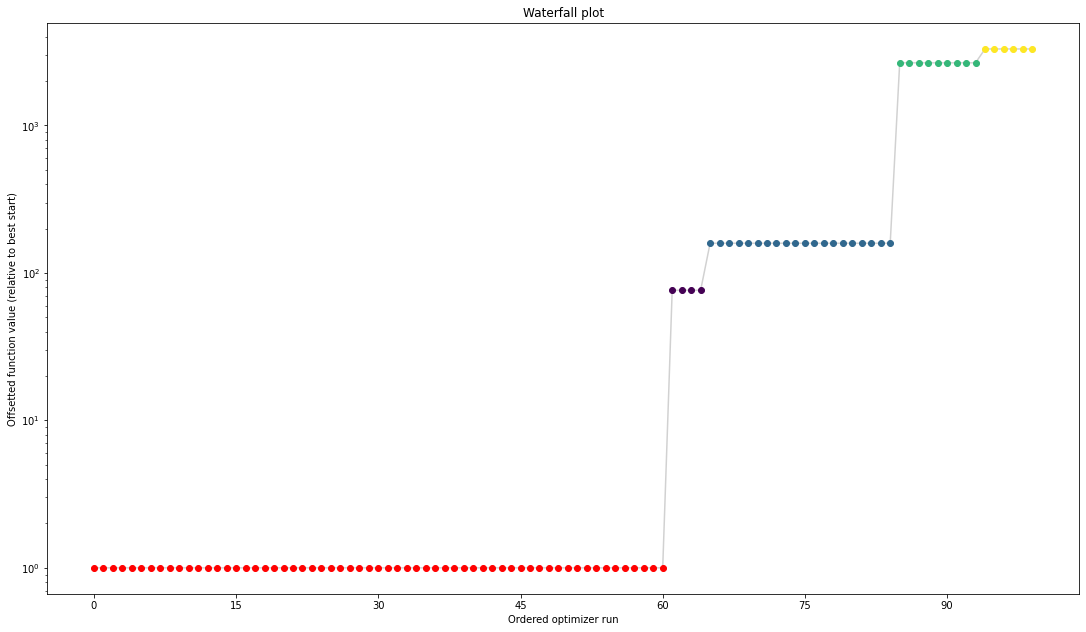

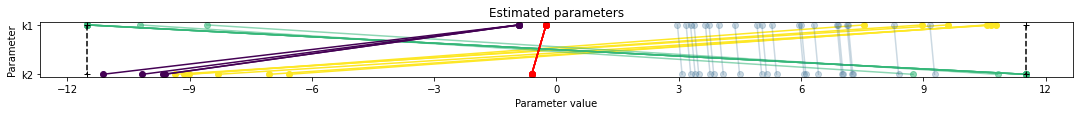

In [5]:
x_mle_unscaled_original = get_x_mle(pypesto_result_original.optimize_result,
                                    pypesto_problem_original,
                                    petab_problem_original,
                                    scaled=False)
print('Parameters are estimated to be (linear scale):')
print('\n'.join([f'{x_id}: {x_value}' for x_id, x_value in x_mle_unscaled_original.items()]))

pypesto.visualize.waterfall(pypesto_result_original);
pypesto.visualize.parameters(pypesto_result_original);

# Synthetic Optimization
Similar to the standard optimization, except the PEtab measurements table is replaced with synthetic data that is generated from specified parameters, with noise, and then used for optimization.

Here, parameters are specified with a dictionary that is used to update the original PEtab parameters table. An alternative is use a second PEtab YAML file that is identical to the original, except for the parameters table, which would now contain the parameter values to be used for synthetic data generation.

## Noise
Noise is added to the simulated data according to the:
- noise distribution in the PEtab observables table;
- noise formula in the PEtab observables table, which is used to calculate the scale of the noise distribution; and
- noise parameters in the PEtab measurements table, which are substituted into the noise formula for measurement-specific noise distribution scales.

**6.** As before, load a PEtab problem. This time, the parameters table is edited to contain parameters values that will be used for synthetic data generation (`synthetic_parameters`). Then, the simulator is used to generate synthetic data, which replaces the measurements table of the PEtab problem for parameter estimation in the next step.

Here, synthetic data also has noise added (`noise=True`), which is defined by the PEtab problem as described above. A noise scaling factor can also be specified (here, a small value - `noise_scaling_factor=0.01` - is used, to reduce noise such that the synthetic parameters are more likely to be recovered with parameter estimation).

The simulator working directory is then deleted along with its contents.

In [6]:
petab_problem_synthetic = petab.Problem.from_yaml(petab_yaml_filename)

synthetic_parameters = {'k1': 1.5, 'k2': 2.5}
petab_problem_synthetic.parameter_df[petab.C.NOMINAL_VALUE].update(synthetic_parameters)

simulator = amici.petab_simulate.PetabSimulator(petab_problem_synthetic)
# Optional: the AMICI simulator is provided a model, to avoid recompilation
petab_problem_synthetic.measurement_df = simulator.simulate(
    noise=True,
    noise_scaling_factor=0.01,
    amici_model=pypesto_problem_original.objective.amici_model,
)
simulator.remove_working_dir()

**7.** Create a pyPESTO problem from the edited PEtab problem, and estimate parameters.

In [7]:
pypesto_importer_synthetic = pypesto.petab.PetabImporter(petab_problem_synthetic)
pypesto_problem_synthetic = pypesto_importer_synthetic.create_problem()
pypesto_result_synthetic = pypesto.optimize.minimize(pypesto_problem_synthetic, n_starts=100)

Function values from history and optimizer do not match: -24.31965832797165, 1439.3853896684805
Parameters obtained from history and optimizer do not match: [0.10235171 0.50828654], [-10.9022877   11.51292546]


**8.** Visualize parameter estimation. Here, the estimates for `k1` and `k2` are similar to the synthetic parameters, suggesting that parameter estimation works well with this PEtab problem and can be used to identify parameter values successfully (**caveat**: noise is reduced here; parameter estimation can be expected to perform worse with more realistically noisy data).

Parameters are estimated to be (linear scale):
k1: 1.4969201262521281
k2: 2.494299196042553


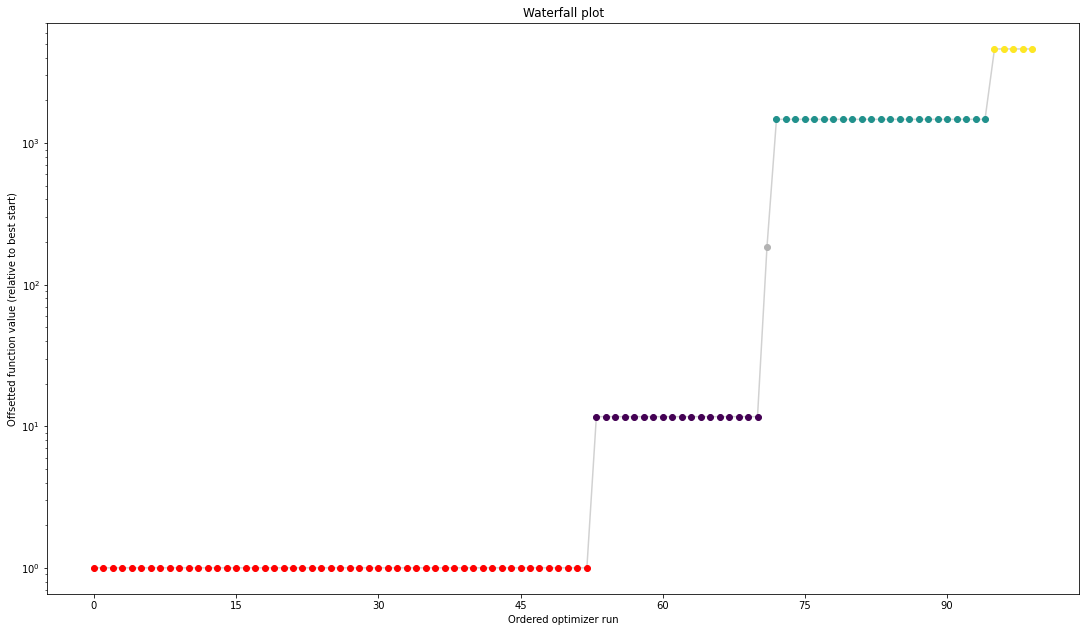

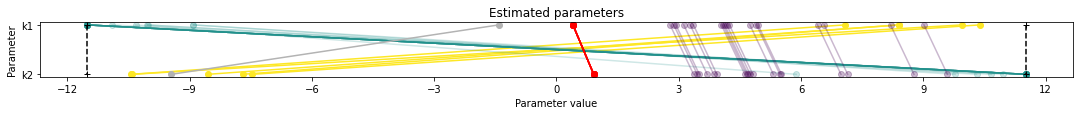

In [8]:
x_mle_unscaled_synthetic = get_x_mle(pypesto_result_synthetic.optimize_result,
                                     pypesto_problem_synthetic,
                                     petab_problem_synthetic,
                                     scaled=False)
print('Parameters are estimated to be (linear scale):')
print('\n'.join([f'{x_id}: {x_value}' for x_id, x_value in x_mle_unscaled_synthetic.items()]))

pypesto.visualize.waterfall(pypesto_result_synthetic);
pypesto.visualize.parameters(pypesto_result_synthetic);